## Approach:
The overall strategy is to replicate the "market", or a 50/50 weighted average between the S&P 500 and TSX 60 sector composition. As such, our simulated portfolio aims to be similarly diversified by weighting stocks according to the sector’s actual market representation. For each sector, the algorithm assigns every stock a correlation coefficient, with stocks that move most similarly to the industry based on historical data from roughly the past year having a higher correlation. Once these coefficients are identified, a pairing algorithm is run that pairs sectors with the highest possible correlation given constraints, with the number of stocks selected for each sector based on the sector’s weight in the "market". More formally, for each industry, N stocks are chosen, where N is calculated as a percentage of the sector’s weight in the respective index divided by two, multiplied by a constant, and floored (see driving code). Additionally, beacuse we aim to keep stocks below a certain percentage of our total portfolio to minimalize non-systematic risk, the algorithm will assign each stock as most M times to (not necessarily distinct) sectors, where M is calculated based on constants that are optimized for (again, see driving code).

## Set up
1. We found out that there are tickers on Yahoo Finance that trackes the S&P 500 and TSX 60 by sectors, they can be seen below.

2. However, the TSX Tickers do not have historical data past 5d on Yahoo, and thus we will manually get the sector composition with every TSX60 stock.

3. After obtaining a list of all S&P 500 and TSX 60 stocks, we were able to classify each stock based on sector. The resulting distribution is also given below.

4. All constants used in our code can be found from constraints specified by the assignment. No further constants are used, aside from numbers optimized based on exisiting constants as seen in the driving code.

| Sector                 | Composition in S&P500 (%) | Composition in TSX60 (%) | S&P Ticker | TSX Ticker  |
|------------------------|----------------------|--------------------|-----------------|---------------|
| Basic Materials        | 1.71              | 8.49            | ^SP500-15       | ^GSPTTMT      |
| Industrials            | 7.19              | 13.11            | ^SP500-20       | ^GSPTTIN      |
| Consumer Cyclical      | 10.75              | 5.31            | ^SP500-25       | ^GSPTTCD      |
| Consumer Defensive     | 5.76              | 5.09            | ^SP500-30       | ^GSPTTCS      |
| Healthcare             | 10.14              | 0            | ^SP500-35       | ^GSPTTHC      |
| Financial Services     | 13.03              | 33.87            | ^SP500-40       | ^SPTTFS       |
| Technology             | 30.45              | 9.63            | ^SP500-45       | ^SPTTTK       |
| Communication Services | 13.40              | 3.04            | ^SP500-50       | ^GSPTTTS      |
| Utilities              | 2.35              | 3.18            | ^SP500-55       | ^GSPTTUT      |
| Real Estate            | 2.07              | 0.62            | ^SP500-60       | ^GSPTTRE      |
| Energy                 | 3.15              | 17.66            | ^SP500-1010     | ^SPTTEN       |



In [46]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import threading
import sys
import time
from datetime import date

ATTRIBUTES = ['sector', 'exchange', 'currency', 'marketCap', 'previousClose']
START_DATE = '2023-10-01'
END_DATE = '2024-11-22'
END_DATE_VOL = '2024-10-01'
MIN_STOCKS = 12
MAX_STOCKS = 24
MIN_PCT = 1/(2*MAX_STOCKS)
MAX_PCT = 0.15
PORTFOLIO_VALUE = 1e6
LAST_CALL = 0.0
WAIT_TIME = 0.5
PERIOD_START = date(2024, 11, 22)
PERIOD_END = date(2024, 12, 2)
FLAT_FEE = 3.95
PER_SHARE_FEE = 0.001

# Each industry is mapped to (% share of S&P500, % share of TSX60, S&P industry ticker, TSX60 capped industry ticker)
# To obtain values for % share, run market_by_sector(SP500_STOCKS) and market_by_sector(TSX60_STOCKS), respectively (see next cell)
# Since % share changes quarterly, we don't need to run this every time
SECTORS = {
    'Basic Materials': (0.0171, 0.0849, '^SP500-15', '^GSPTTMT'),
    'Industrials': (0.0719, 0.1311, '^SP500-20', '^GSPTTIN'),
    'Consumer Cyclical': (0.1075, 0.0531, '^SP500-25', '^GSPTTCD'),
    'Consumer Defensive': (0.0576, 0.0509, '^SP500-30', '^GSPTTCS'),
    'Healthcare': (0.1014, 0.0000, '^SP500-35', '^GSPTTHC'),
    'Financial Services': (0.1303, 0.3387, '^SP500-40', '^SPTTFS'),
    'Technology': (0.3045, 0.0963, '^SP500-45', '^SPTTTK'),
    'Communication Services': (0.1340, 0.0304, '^SP500-50', '^GSPTTTS'),
    'Utilities': (0.0235, 0.0318, '^SP500-55', '^GSPTTUT'),
    'Real Estate': (0.0207, 0.0062, '^SP500-60', '^GSPTTRE'),
    'Energy': (0.0315, 0.1766, '^SP500-1010', '^SPTTEN')
}

TSX60_STOCKS = ['ABX.TO','AEM.TO','AQN.TO','ATD.TO','BAM.TO','BCE.TO','BIP-UN.TO','BMO.TO','BN.TO','BNS.TO','CAE.TO','CAR-UN.TO','CCL-B.TO','CCO.TO','CM.TO','CNQ.TO','CNR.TO','CP.TO','CSU.TO','CTC-A.TO','CVE.TO','DOL.TO','EMA.TO','ENB.TO','FM.TO','FNV.TO','FSV.TO','FTS.TO','GIB-A.TO','GIL.TO','H.TO','IFC.TO','IMO.TO','K.TO','L.TO','MFC.TO','MG.TO','MRU.TO','NA.TO','NTR.TO','OTEX.TO','POW.TO','PPL.TO','QSR.TO','RCI-B.TO','RY.TO','SAP.TO','SHOP.TO','SLF.TO','SU.TO','T.TO','TD.TO','TECK-B.TO','TOU.TO','TRI.TO','TRP.TO','WCN.TO','WN.TO','WPM.TO','WSP.TO']

SP500_STOCKS = ['A','AAPL','ABBV','ABNB','ABT','ACGL','ACN','ADBE','ADI','ADM','ADP','ADSK','AEE','AEP','AES','AFL','AIG','AIZ','AJG','AKAM','ALB','ALGN','ALL','ALLE','AMAT','AMCR','AMD','AME','AMGN','AMP','AMT','AMTM','AMZN','ANET','ANSS','AON','AOS','APA','APD','APH','APTV','ARE','ATO','AVB','AVGO','AVY','AWK','AXON','AXP','AZO','BA','BAC','BALL','BAX','BBY','BDX','BEN','BF-B','BG','BIIB','BK','BKNG','BKR','BLDR','BLK','BMY','BR','BRK-B','BRO','BSX','BWA','BX','BXP','C','CAG','CAH','CARR','CAT','CB','CBOE','CBRE','CCI','CCL','CDNS','CDW','CE','CEG','CF','CFG','CHD','CHRW','CHTR','CI','CINF','CL','CLX','CMCSA','CME','CMG','CMI','CMS','CNC','CNP','COF','COO','COP','COR','COST','CPAY','CPB','CPRT','CPT','CRL','CRM','CRWD','CSCO','CSGP','CSX','CTAS','CTLT','CTRA','CTSH','CTVA','CVS','CVX','CZR','D','DAL','DAY','DD','DE','DECK','DELL','DFS','DG','DGX','DHI','DHR','DIS','DLR','DLTR','DOC','DOV','DOW','DPZ','DRI','DTE','DUK','DVA','DVN','DXCM','EA','EBAY','ECL','ED','EFX','EG','EIX','EL','ELV','EMN','EMR','ENPH','EOG','EPAM','EQIX','EQR','EQT','ERIE','ES','ESS','ETN','ETR','EVRG','EW','EXC','EXPD','EXPE','EXR','F','FANG','FAST','FCX','FDS','FDX','FE','FFIV','FI','FICO','FIS','FITB','FMC','FOX','FOXA','FRT','FSLR','FTNT','FTV','GD','GDDY','GE','GEHC','GEN','GEV','GILD','GIS','GL','GLW','GM','GNRC','GOOG','GOOGL','GPC','GPN','GRMN','GS','GWW','HAL','HAS','HBAN','HCA','HD','HES','HIG','HII','HLT','HOLX','HON','HPE','HPQ','HRL','HSIC','HST','HSY','HUBB','HUM','HWM','IBM','ICE','IDXX','IEX','IFF','INCY','INTC','INTU','INVH','IP','IPG','IQV','IR','IRM','ISRG','IT','ITW','IVZ','J','JBHT','JBL','JCI','JKHY','JNJ','JNPR','JPM','K','KDP','KEY','KEYS','KHC','KIM','KKR','KLAC','KMB','KMI','KMX','KO','KR','KVUE','L','LDOS','LEN','LH','LHX','LIN','LKQ','LLY','LMT','LNT','LOW','LRCX','LULU','LUV','LVS','LW','LYB','LYV','MA','MAA','MAR','MAS','MCD','MCHP','MCK','MCO','MDLZ','MDT','MET','META','MGM','MHK','MKC','MKTX','MLM','MMC','MMM','MNST','MO','MOH','MOS','MPC','MPWR','MRK','MRNA','MRO','MS','MSCI','MSFT','MSI','MTB','MTCH','MTD','MU','NCLH','NDAQ','NDSN','NEE','NEM','NFLX','NI','NKE','NOC','NOW','NRG','NSC','NTAP','NTRS','NUE','NVDA','NVR','NWS','NWSA','NXPI','O','ODFL','OKE','OMC','ON','ORCL','ORLY','OTIS','OXY','PANW','PARA','PAYC','PAYX','PCAR','PCG','PEG','PEP','PFE','PFG','PG','PGR','PH','PHM','PKG','PLD','PLTR','PM','PNC','PNR','PNW','PODD','POOL','PPG','PPL','PRU','PSA','PSX','PTC','PWR','PYPL','QCOM','QRVO','RCL','REG','REGN','RF','RJF','RL','RMD','ROK','ROL','ROP','ROST','RSG','RTX','RVTY','SBAC','SBUX','SCHW','SHW','SJM','SLB','SMCI','SNA','SNPS','SO','SOLV','SPG','SPGI','SRE','STE','STLD','STT','STX','STZ','SW','SWK','SWKS','SYF','SYK','SYY','T','TAP','TDG','TDY','TECH','TEL','TER','TFC','TFX','TGT','TJX','TMO','TMUS','TPR','TRGP','TRMB','TROW','TRV','TSCO','TSLA','TSN','TT','TTWO','TXN','TXT','TYL','UAL','UBER','UDR','UHS','ULTA','UNH','UNP','UPS','URI','USB','V','VICI','VLO','VLTO','VMC','VRSK','VRSN','VRTX','VST','VTR','VTRS','VZ','WAB','WAT','WBA','WBD','WDC','WEC','WELL','WFC','WM','WMB','WMT','WRB','WST','WTW','WY','WYNN','XEL','XOM','XYL','YUM','ZBH','ZBRA','ZTS']

In [47]:
# adds market cap of ticker to data table
def ticker_by_sector(ticker, data):
    global LAST_CALL
    if(time.time() - LAST_CALL < WAIT_TIME):
        time.sleep(WAIT_TIME-(time.time()-LAST_CALL))
    LAST_CALL = time.time()
    yf_data = yf.Ticker(ticker).info
    data[yf_data['sector']] += yf_data['marketCap']

# prints percentage of index in each sector
def market_by_sector(index):
    data = {sector: 0 for sector in SECTORS}
    threads = [threading.Thread(target=ticker_by_sector, args=(ticker,data)) for ticker in index]
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    sum = 0
    for sector in data:
        sum += data[sector]
    for sector in data:
        print(sector, 'accounts for', round(data[sector]/sum*100, 2), 'percent of', index)

# uncomment these to get the % share of each sector in the S&P500 and TSX60 as in cell above
# market_by_sector(SP500_STOCKS)
# market_by_sector(TSX60_STOCKS)

## Fetch Data

Ticker data is obtained from the functions below. As specified, we filtered out stocks that are not listed in CAD/USD as well as those having less than 100,000 average monthly volume. In addition, we removed all stocks whose earnings are released during the duration of the competition (see Why Remove Stocks with Earnings section).

In [48]:
# adds ticker info to data df
def get_data(ticker, data, history, filter):
    global LAST_CALL
    if(time.time() - LAST_CALL < WAIT_TIME):
        time.sleep(WAIT_TIME-(time.time()-LAST_CALL))
    LAST_CALL = time.time()
    yf_data = yf.Ticker(ticker).info
    if(not filter):
        for att in ATTRIBUTES:
            if(att not in yf_data):
                print(ticker, 'missing', att)
                continue
            data.loc[ticker, att] = yf_data[att]
        if(time.time() - LAST_CALL < WAIT_TIME):
            time.sleep(WAIT_TIME-(time.time()-LAST_CALL))
        LAST_CALL = time.time()
        hist = yf.Ticker(ticker).history(start=START_DATE, end=END_DATE)
        history[ticker] = hist['Close'].pct_change().dropna()
        return
    # check if stock is CAD or USD
    if('currency' not in yf_data or yf_data['currency'] not in ['USD', 'CAD']):
        data.drop(ticker, inplace=True)
        print('Dropped', ticker)
        return
    for att in ATTRIBUTES:
        if(att not in yf_data):
            print(ticker, 'missing', att)
            continue
        data.loc[ticker, att] = yf_data[att]
    if(time.time() - LAST_CALL < WAIT_TIME):
        time.sleep(WAIT_TIME-(time.time()-LAST_CALL))
    LAST_CALL = time.time()
    hist = yf.Ticker(ticker).history(start=START_DATE, end=END_DATE)
    history[ticker] = hist['Close'].pct_change().dropna()
    vol = yf.Ticker(ticker=ticker).history(start=START_DATE, end=END_DATE_VOL)
    volume = vol['Volume'].resample('MS').sum()
    # Take all months with >= 18 trading days for volume calculation
    volume.drop([month for month in volume.index if hist.resample('MS').size().loc[month] < 18], inplace=True)
    # check if stock has at least 100,000 average monthly volume
    if(volume.mean() < 1e5):
        data.drop(ticker, inplace=True)
        print('Dropped', ticker, 'due to insufficient volume')
    # check if stock has earnings this week
    earning_date = yf.Ticker(ticker).calendar['Earnings Date']
    if(len(earning_date) > 0 and PERIOD_START <= earning_date[0] <= PERIOD_END):
        print('Dropped', ticker, 'because earnings are this week')
        data.drop(ticker, inplace=True)
        return

# returns df containing all ticker info
def get_tickers(filter=True):
    with threading.Lock():
        tickers = pd.read_csv('Tickers.csv', header=None) if filter else [TSX60_STOCKS]
        data = pd.DataFrame(index=[ticker for ticker in tickers[0]], columns=ATTRIBUTES)
        history = {}
        threads = [threading.Thread(target=get_data, args=(ticker,data,history,filter)) for ticker in tickers[0]]
        for thread in threads:
            thread.start()
        for thread in threads:
            thread.join()
    return (data, history)

## Matching Algorithm

The `weighted_max_bipartite_matching` function is a matching algorithm to assign stocks to sectors while maximizing the overall weight. To handle multiple stock requirements for each sector, the function first expands the graph, resulting in an extended matrix `expanded_C`. The function then iteratively improves the matching through augmenting paths, a concept related to the [vertex cover problem](https://en.wikipedia.org/wiki/Vertex_cover). While a high-level understanding of the algorithm was realized ([this](https://www.youtube.com/watch?v=T4TrFA39AJU&ab_channel=OptWhiz) is an excellent youtube explanation), implementation was done with AI, as mentioned in the AI declaration above.

In [49]:
def weighted_max_bipartite_matching(N, M, A, C):
    """
    Finds the weighted maximum bipartite matching for sectors and stocks.
    
    Args:
    - N: Number of sectors.
    - M: Number of stocks.
    - A: List of length N where A[i] is the number of stocks required by sector i.
    - C: 2D list (N x M) of weights (correlations) between sectors and stocks.
    
    Returns:
    - match: List of tuples (sector, stock) representing the matching.
    - total_weight: Total weight of the matching.
    """
    # Expand the graph: create dummy nodes for each sector demand
    total_sectors = sum(A)
    expanded_C = [[-sys.maxsize] * M for _ in range(total_sectors)]
    
    sector_mapping = []
    index = 0
    for i in range(N):
        for _ in range(A[i]):
            expanded_C[index] = C[i]
            sector_mapping.append(i)  # Map expanded sector to original sector
            index += 1

    # Hungarian algorithm for max-weight matching
    match = [-1] * M  # Stores which sector is assigned to each stock
    sector_label = [0] * total_sectors
    stock_label = [0] * M
    slack = [0] * M
    slack_x = [-1] * M
     
    def dfs(x, visited_x, visited_y):
        visited_x[x] = True
        for y in range(M):
            if visited_y[y]:
                continue
            delta = sector_label[x] + stock_label[y] - expanded_C[x][y]
            if delta == 0:  # Tight edge
                visited_y[y] = True
                if match[y] == -1 or dfs(match[y], visited_x, visited_y):
                    match[y] = x
                    return True
            else:  # Update slack
                if slack[y] > delta:
                    slack[y] = delta
                    slack_x[y] = x
        return False

    # Initialize labels
    for x in range(total_sectors):
        sector_label[x] = max(expanded_C[x])

    # Augmenting path search
    for x in range(total_sectors):
        slack = [sys.maxsize] * M
        slack_x = [-1] * M
        while True:
            visited_x = [False] * total_sectors
            visited_y = [False] * M
            if dfs(x, visited_x, visited_y):
                break
            # Update labels
            delta = min(slack[y] for y in range(M) if not visited_y[y])
            for i in range(total_sectors):
                if visited_x[i]:
                    sector_label[i] -= delta
            for y in range(M):
                if visited_y[y]:
                    stock_label[y] += delta
                else:
                    slack[y] -= delta

    # Extract results
    total_weight = 0
    final_match = []
    for y in range(M):
        if match[y] != -1:
            sector_idx = sector_mapping[match[y]]
            final_match.append((sector_idx, y))
            total_weight += C[sector_idx][y]

    return final_match

## Portfolio Creation and Helper Functions

Here is the core of our algorithm. As aforementioned, we decided to select stocks by their correlation (see Why Correlation section) to different sectors.

We start constructing the portfolio by calculating the correlation for each stock relative to the sectors. These calculations identifies the stocks that will most accurately represent their respective sectors in the portfolio. Our goal is to maintain a balance between minimizing risk through diversification and assigning each sector the best correlated stock(s). Since a single stock may be correlated to multiple, possibly highly weighted sectors, we run the bipartite matching algorithm to cap each stock while finding the maximal sum of all correlation values in the resulting portfolio in O(VE), where V is the sum of sectors and stocks, and E is the product of sectors and stocks.

We also optimize the calculation of our "unit", the weight of a single stock in the resulting bipartite matching algorithm through binary search, which allows us to cap the number of stocks in the final portfolio at 24 while maintaining the diversification constraints.


In [50]:
# divide by 2 since each index is 50% of the "market"
def adjust_sector_cap():
    for sector in SECTORS:
        SECTORS[sector] = (SECTORS[sector][0]/2, SECTORS[sector][1]/2, SECTORS[sector][2], SECTORS[sector][3])

# binary search for optimal max percentage of a single stock such that we can have 24 stocks in our portfolio
def unit_percentage(max_stocks):
    low = MIN_PCT
    high = 1.0
    while(low < high):
        mid = (low+high)/2
        sum = 0
        for sector in SECTORS:
            sum += min(max(1, SECTORS[sector][0]//mid), SECTORS[sector][0]//MIN_PCT) + min(max(1, SECTORS[sector][1]//mid), SECTORS[sector][1]//MIN_PCT)
        if(sum > max_stocks):
            low = mid+0.0001
        else:
            high = mid-0.0001
    return low

# returns sector and index given a ticker from sectors dictionary
# 0 for S&P500, 1 for TSX60
def ticker_to_sector(ticker):
    for sector in SECTORS:
        if(ticker == SECTORS[sector][2]):
            return sector, 0
        if(ticker == SECTORS[sector][3]):
            return sector, 1
    return None

def beta(df, stock, sector):
    return df[stock].cov(df[sector])/df[sector].var()

def corr(df, stock, sector):
    return df[stock].corr(df[sector])

# returns function of stocks to sectors as given by f
# 0 for S&P500, 1 for TSX60
def calc(data, history, f, index):
    sector_metric = {stock:{} for stock in data.index}
    for sector in SECTORS:
        for stock in data.index:
            if(SECTORS[sector][index] == 0):
                continue
            df = pd.DataFrame({stock: history[stock], sector: history[SECTORS[sector][2+index]]}).dropna()
            # calculate metric given a function f
            sector_metric[stock][sector] = f(df, stock, sector)
    return sector_metric

# returns df containing history for each sector in TSX60
# since historical data for individual TSX60 sectors is unavailable, we take the weighted average of all stocks in each sector
def tsx_sectors():
    data, history = get_tickers(False)
    sector_history = pd.DataFrame({SECTORS[sector][3]: 0 for sector in SECTORS}, index=history[data.index[0]].index)
    total_market_cap = {SECTORS[sector][3]: 0 for sector in SECTORS}
    for stock in history:
        total_market_cap[SECTORS[data['sector'].loc[stock]][3]] += data['marketCap'].loc[stock]
    for stock in history:
        sector = SECTORS[data['sector'].loc[stock]][3]
        sector_history[sector] += history[stock]*data['marketCap'].loc[stock]/total_market_cap[sector]
    return sector_history

# returns df containing history for each sector in S&P500
def sp_sectors():
    history = {SECTORS[sector][2]: yf.Ticker(SECTORS[sector][2]).history(start=START_DATE, end=END_DATE)['Close'].pct_change().dropna() for sector in SECTORS}
    return pd.DataFrame(history, index=list(history.values())[0].index)

# creates the portfolio
def create_portfolio(data, sector_corr, unit_pct, pct_cap):
    portfolio = {stock: 0 for stock in data.index}
    # maps sector to index to be used in bipartite matching
    SECTOR_IDX = {}
    # maps index to sector to convert back after matching
    IDX_SECTOR = {}
    # maps stock to index to be used in bipartite matching
    STOCK_IDX = {}
    # maps index to stock to convert back after matching
    IDX_STOCK = {}
    idx = 0
    for sector in SECTORS:
        SECTOR_IDX[SECTORS[sector][2]] = idx # S&P500
        IDX_SECTOR[idx] = SECTORS[sector][2] # S&P500
        SECTOR_IDX[SECTORS[sector][3]] = idx+1 # TSX60
        IDX_SECTOR[idx+1] = SECTORS[sector][3] # TSX60
        idx += 2
    idx = 0
    for stock in data.index:
        for i in range(int(pct_cap/unit_pct)):
            STOCK_IDX[stock] = idx
            IDX_STOCK[idx] = stock
            idx += 1
    CORR = [[] for _ in SECTOR_IDX]
    NUM_STOCKS = [0 for _ in SECTOR_IDX]
    for sector in SECTORS:
        for i in range(2):
            if(SECTORS[sector][i] < MIN_PCT): # also checks if sector has no percentage
                continue
            for j in range(len(IDX_STOCK)):
                CORR[SECTOR_IDX[SECTORS[sector][2+i]]].append(int((10-abs(sector_corr[i][IDX_STOCK[j]][sector]-1))*1000)+10000) # weight of edge between sector and stock
            NUM_STOCKS[SECTOR_IDX[SECTORS[sector][2+i]]] = int(min(max(1, SECTORS[sector][i]//unit_pct), SECTORS[sector][i]//MIN_PCT)) # number of stocks required by sector
    result = weighted_max_bipartite_matching(len(SECTOR_IDX), len(IDX_STOCK), NUM_STOCKS, CORR)
    # adds stocks from matching to portfolio
    for pair in result:
        sector, idx = ticker_to_sector(IDX_SECTOR[pair[0]])
        portfolio[IDX_STOCK[pair[1]]] += unit_pct if SECTORS[sector][idx] >= unit_pct else SECTORS[sector][idx]
    # adds stocks best correlated with remaining sectors to portfolio and fills all sector quotas with highest correlated stocks
    for sector in SECTORS:
        for i in range(2):
            remaining = SECTORS[sector][i] - SECTORS[sector][i]//unit_pct*unit_pct
            if(remaining == 0 or (SECTORS[sector][i] >= MIN_PCT and SECTORS[sector][i] < unit_pct)):
                continue
            best_corr = sector_corr[i][IDX_STOCK[0]][sector]
            best_stock = IDX_STOCK[0]
            for j in range(len(IDX_STOCK)):
                if(portfolio[IDX_STOCK[j]] != 0 and sector_corr[i][IDX_STOCK[j]][sector] > best_corr and portfolio[IDX_STOCK[j]]+remaining <= MAX_PCT):
                    best_corr = sector_corr[i][IDX_STOCK[j]][sector]
                    best_stock = IDX_STOCK[j]
            portfolio[best_stock] += remaining
    sum = 0
    count = 0
    for stock in portfolio:
        portfolio[stock] = round(portfolio[stock], 4)
        sum += portfolio[stock]
        count += 1 if portfolio[stock] != 0 else 0
    for stock in portfolio:
        if(portfolio[stock] != 0):
            portfolio[stock] += round(1-sum, 4)
            portfolio[stock] = round(portfolio[stock], 4)
            sum = 1.0
            break
    return portfolio, sum, count

# calculates portfolio error relative to weighted index
def portfolio_error(historical_data, weighted_index):
    return (historical_data-weighted_index).abs().sum()

# returns sector percent change since start date
def aggregate_pct_change(history):
    result = pd.Series(index=history.index)
    prev = 1
    for day in history.index:
        if(pd.isna(history[day])):
            continue
        result[day] = prev*(1+history[day])
        prev = result[day]
    return result

# calculate how many shares one can buy, including fees
def calc_shares(value, price):
    return max(value/(price+PER_SHARE_FEE), (value-FLAT_FEE)/price)

## Driver Code

We start by obtaining all the data we need to construct our portfolio. Then, we loop through all percentage caps for any given stock from `MIN_PCT` to `MAX_PCT` (see constants at top of notebook). In addition, for each percentage cap, we also loop through all caps on the number of stocks we can have, effectively creating a new portfolio each time. Since our portfolio creation is optimized to cubic time, we can run the entire algorithm in under a minute given at most ~50 stocks. By taking the best portfolio based on historical data over the past year, we then obtain our final portfolio.

In [51]:
adjust_sector_cap() # divides sector caps by 2
data, history = get_tickers() # gets all ticker data
tsx_by_sector = tsx_sectors() # gets TSX60 sector data
for sector in tsx_by_sector:
    history[sector] = tsx_by_sector[sector] # adds TSX60 sector data to history
sp_by_sector = sp_sectors() # gets S&P500 sector data
for sector in sp_by_sector:
    history[sector] = sp_by_sector[sector] # adds S&P500 sector data to history
sector_corr = [calc(data, history, corr, 0), calc(data, history, corr, 1)] # calculates correlation between sectors and stocks [S&P500, TSX60]
print('Data loaded')
portfolio = {}
best_error = 1e9
best_unit_pct = 0
best_pct_cap = 0
pct_cap = unit_percentage(MAX_STOCKS)
weighted_index = pd.Series(0, index=history[list(history.keys())[0]].index)
for sector in SECTORS:
    for i in range(2):
        weighted_index += SECTORS[sector][i]*history[SECTORS[sector][2+i]] # adds sector price history to weighted index
while(pct_cap < MAX_PCT): # finds optimal pct_cap (max percentage of a single stock before miscellaneous adds) for portfolio
    test_stocks = MAX_STOCKS # max number of stocks in portfolio, gets increased as long as the algorithm returns less than MAX_STOCKS stocks
    MIN_PCT = 1/(2*test_stocks)
    unit_pct = unit_percentage(test_stocks)
    stocks = 0
    flag = False
    while(stocks < MIN_STOCKS and not flag): # if we can't find a portfolio with at least MIN_STOCKS stocks, we increase test_stocks
        if(test_stocks > 2*MAX_STOCKS):
            flag = True # no possible portfolio with given pct_cap
        cur_portfolio, tot, stocks = create_portfolio(data, sector_corr, unit_pct, pct_cap)
        test_stocks += 1
        MIN_PCT = 1/(2*test_stocks)
        unit_pct = unit_percentage(test_stocks)
    repeated_stock_count = 0 # stops looping if we can't find a portfolio with a larger number of stocks for 10 iterations
    while(not flag and stocks <= MAX_STOCKS and repeated_stock_count < 10):
        stocks_to_buy = [stock for stock in cur_portfolio if cur_portfolio[stock] != 0]
        historical_data = pd.Series(0, index=history[stocks_to_buy[0]].index)
        for stock in stocks_to_buy:
            historical_data += cur_portfolio[stock]*history[stock]
        cur_error = portfolio_error(historical_data, weighted_index)
        if(cur_error < best_error): # updates best portfolio found so far
            best_error = cur_error
            best_unit_pct = unit_pct
            best_pct_cap = pct_cap
            portfolio = dict(cur_portfolio)
        test_stocks += 1
        MIN_PCT = 1/(2*test_stocks)
        unit_pct = unit_percentage(test_stocks)
        cur_portfolio, tot, cur_stocks = create_portfolio(data, sector_corr, unit_pct, pct_cap)
        if(cur_stocks == stocks):
            repeated_stock_count += 1
        else:
            repeated_stock_count = 0
        stocks = cur_stocks
    pct_cap += 0.01
portfolio

Dropped AGN
Dropped RTN
Dropped MON
Dropped CELG
Data loaded


{'AAPL': 0.0424,
 'ABBV': 0.0212,
 'ABT': 0,
 'ACN': 0.0212,
 'AIG': 0.046,
 'AMZN': 0.0573,
 'AXP': 0.0423,
 'BA': 0,
 'BAC': 0.044,
 'BB.TO': 0,
 'BIIB': 0.0507,
 'BK': 0.0423,
 'BLK': 0.0643,
 'BMY': 0,
 'C': 0.0423,
 'CAT': 0.0518,
 'CL': 0.0212,
 'KO': 0.0406,
 'LLY': 0.0423,
 'LMT': 0,
 'MO': 0,
 'MRK': 0,
 'PEP': 0,
 'PFE': 0,
 'PG': 0,
 'PM': 0,
 'PYPL': 0.0212,
 'QCOM': 0.0464,
 'RY.TO': 0.0541,
 'SHOP.TO': 0.0481,
 'T.TO': 0.0311,
 'TD.TO': 0.0423,
 'TXN': 0.0423,
 'UNH': 0,
 'UNP': 0.0423,
 'UPS': 0,
 'USB': 0.0423}

## Data Display

Here is where we organzie our data, and display the dataframe `Portfolio_Final`.

**In the event that any values in the table below are NaN or an error occurs in the cell above, try rerunning all cells. Stocks that have IPO'd within the past year will error—these can be ignored. Other errors may be due to inconsistencies in yfinance calls. If the error persists, try again after ~2 minutes.**

In [52]:
stocks_to_buy = [stock for stock in portfolio if portfolio[stock] != 0]
Portfolio_Final = pd.DataFrame(index=[i+1 for i in range(len(stocks_to_buy))], columns=['Ticker', 'Price', 'Currency', 'Shares', 'Value', 'Weight'])
CAD_TO_USD = yf.Ticker('CADUSD=X').info['previousClose']
for stock in stocks_to_buy:
    idx = stocks_to_buy.index(stock)+1
    Portfolio_Final.loc[idx, 'Ticker'] = stock
    Portfolio_Final.loc[idx, 'Price'] = data['previousClose'].loc[stock]/CAD_TO_USD if data['currency'].loc[stock] == 'USD' else data['previousClose'].loc[stock]
    Portfolio_Final.loc[idx, 'Currency'] = data['currency'].loc[stock]
    Portfolio_Final.loc[idx, 'Shares'] = calc_shares(portfolio[stock]*PORTFOLIO_VALUE, Portfolio_Final.loc[idx, 'Price'])
    Portfolio_Final.loc[idx, 'Value'] = Portfolio_Final.loc[idx, 'Shares']*Portfolio_Final.loc[idx, 'Price']
    Portfolio_Final.loc[idx, 'Weight'] = portfolio[stock]
Portfolio_Final.loc['Total', 'Ticker'] = '--'
Portfolio_Final.loc['Total', 'Price'] = '--'
Portfolio_Final.loc['Total', 'Currency'] = '--'
Portfolio_Final.loc['Total', 'Shares'] = Portfolio_Final['Shares'].sum()
Portfolio_Final.loc['Total', 'Value'] = Portfolio_Final['Value'].sum()
Portfolio_Final.loc['Total', 'Weight'] = Portfolio_Final['Weight'].sum()
print('All dollar values in CAD')
display(Portfolio_Final)

All dollar values in CAD


,Ticker,Price,Currency,Shares,Value,Weight
1,AAPL,319.269858,USD,132.8026,42399.867197,0.0424
2,ABBV,239.927415,USD,88.359689,21199.91164,0.0212
3,ACN,504.43017,USD,42.027538,21199.957972,0.0212
4,AIG,106.153176,USD,433.331986,45999.566668,0.046
5,AMZN,277.160662,USD,206.738549,57299.793261,0.0573
6,AXP,409.356155,USD,103.332749,42299.896667,0.0423
7,BAC,64.910194,USD,677.849182,43999.322151,0.044
8,BIIB,220.758928,USD,229.661245,50699.770339,0.0507
9,BK,110.204824,USD,383.827264,42299.616173,0.0423
10,BLK,1436.239342,USD,44.769666,64299.95523,0.0643


Note that the portfolio does not sum up to exactly $1,000,000 CAD since fees are paid.

## Historical Data

While who knows how our portfolio will fare compared with the "market" over the duration of the competition, here's how the portfolio did against the market over the past year or so.

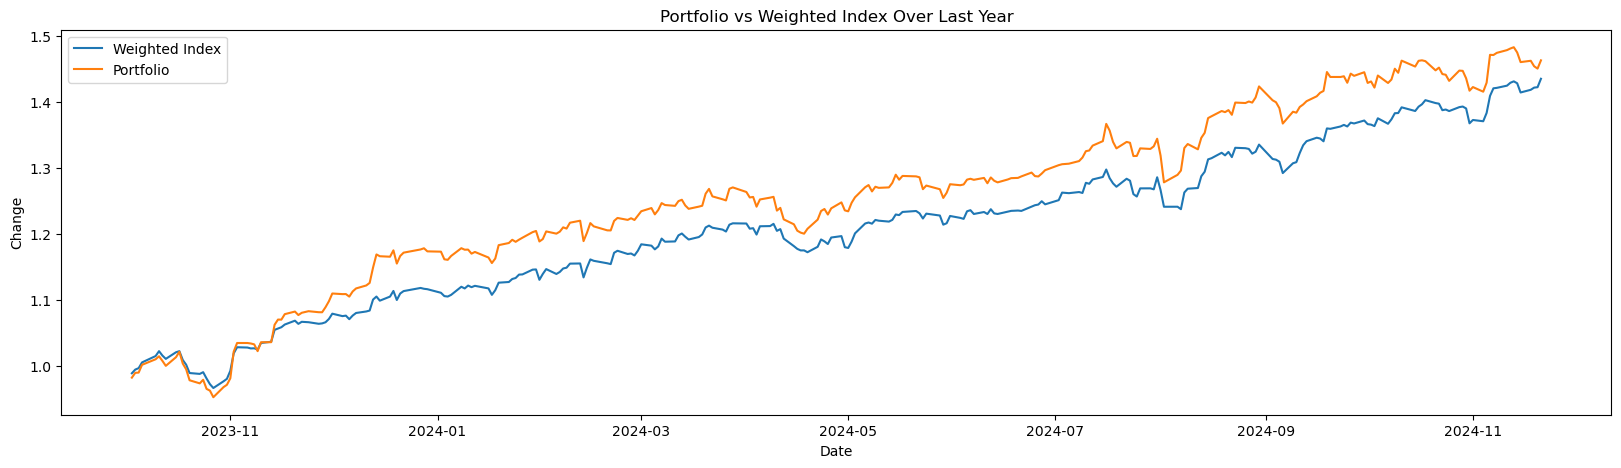

Portfolio error relative to market: 0.8184772683199397


In [ ]:
historical_data = pd.Series(0, index=history[stocks_to_buy[0]].index)
for stock in stocks_to_buy:
    historical_data += portfolio[stock]*history[stock]
plt.figure(figsize=(20, 5))
plt.title('Portfolio vs Weighted Index Over Last Year')
plt.xlabel('Date')
plt.ylabel('Change')
plt.plot(aggregate_pct_change(weighted_index).dropna(), label='Weighted Index')
plt.plot(aggregate_pct_change(historical_data).dropna(), label='Portfolio')

plt.show()
print('Portfolio error relative to market:', portfolio_error(historical_data, weighted_index))

## Why Correlation

You may have noticed we not only have a function to calculate correlation, but also one to calculate beta. So why did we pick correlation as our deciding metric? Well, after running our algorithm on test tickers, the resulting portfolio created while using correlation saw a nearly 30% decrease in total error (as calculated by the sum of all differences between percent changes each day) and a 14% decrease in standard deviation versus the portfolio created while using beta. The exact findings can be found below.

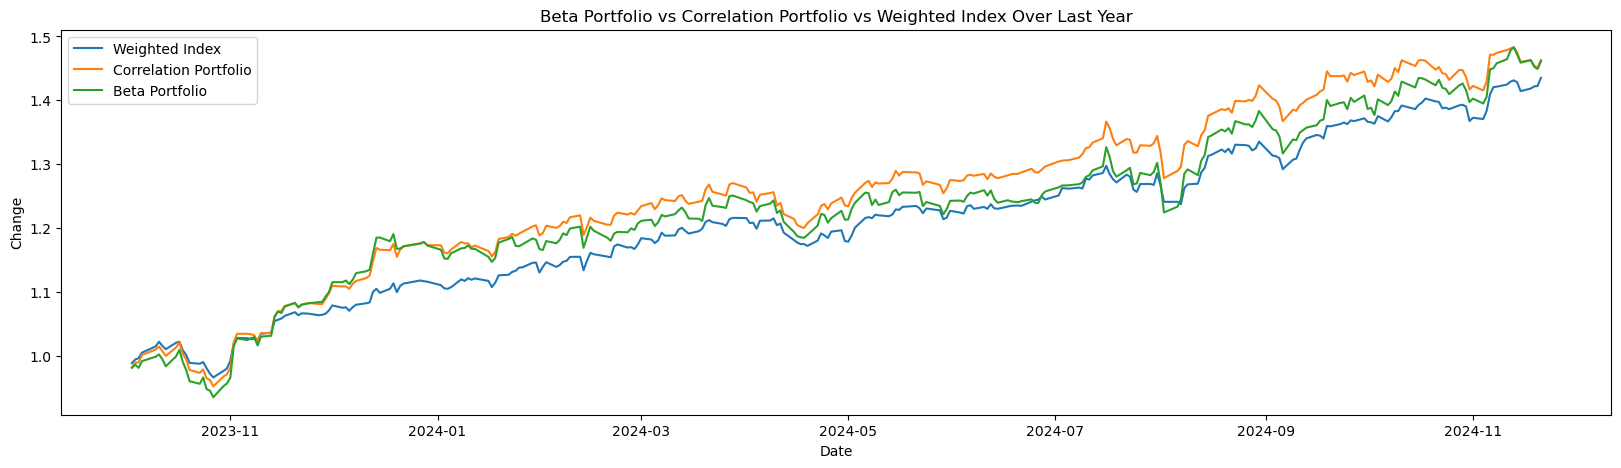

Correlation portfolio error relative to market: 0.8184772683199397
Correlation portfolio percent change standard deviation: 0.008570208861829989
Beta portfolio error relative to market: 1.152505223972311
Beta portfolio percent change standard deviation: 0.010045353549267921


In [54]:
sector_beta = [calc(data, history, beta, 0), calc(data, history, beta, 1)]
beta_portfolio, beta_tot, beta_stocks = create_portfolio(data, sector_beta, best_unit_pct, best_pct_cap) # creates portfolio but using beta instead of correlation
beta_stocks_to_buy = [stock for stock in beta_portfolio if beta_portfolio[stock] != 0]
historical_beta_data = pd.Series(0, index=history[beta_stocks_to_buy[0]].index)
for stock in beta_stocks_to_buy:
    historical_beta_data += beta_portfolio[stock]*history[stock]
plt.figure(figsize=(20, 5))
plt.title('Beta Portfolio vs Correlation Portfolio vs Weighted Index Over Last Year')
plt.xlabel('Date')
plt.ylabel('Change')
plt.plot(aggregate_pct_change(weighted_index).dropna(), label='Weighted Index')
plt.plot(aggregate_pct_change(historical_data).dropna(), label='Correlation Portfolio')
plt.plot(aggregate_pct_change(historical_beta_data).dropna(), label='Beta Portfolio')
plt.legend()
plt.show()
print('Correlation portfolio error relative to market:', portfolio_error(historical_data, weighted_index))
print('Correlation portfolio percent change standard deviation:', historical_data.std())
print('Beta portfolio error relative to market:', portfolio_error(historical_beta_data, weighted_index))
print('Beta portfolio percent change standard deviation:', historical_beta_data.std())

## Why Remove Stocks with Earnings

While the goal of our portfolio is to match the market as closely as possible, we also want to win the competition. As such, we removed all tickers from consideration if their earnings would come out during the competition. Earnings reports are one of the biggest influencers in stock price on a day-to-day level, and we believe an earnings report would make the stock too volatile to add to the portfolio. As an example, here is Target's stock price after missing their earnings estimate by 19% just three days before our competition.

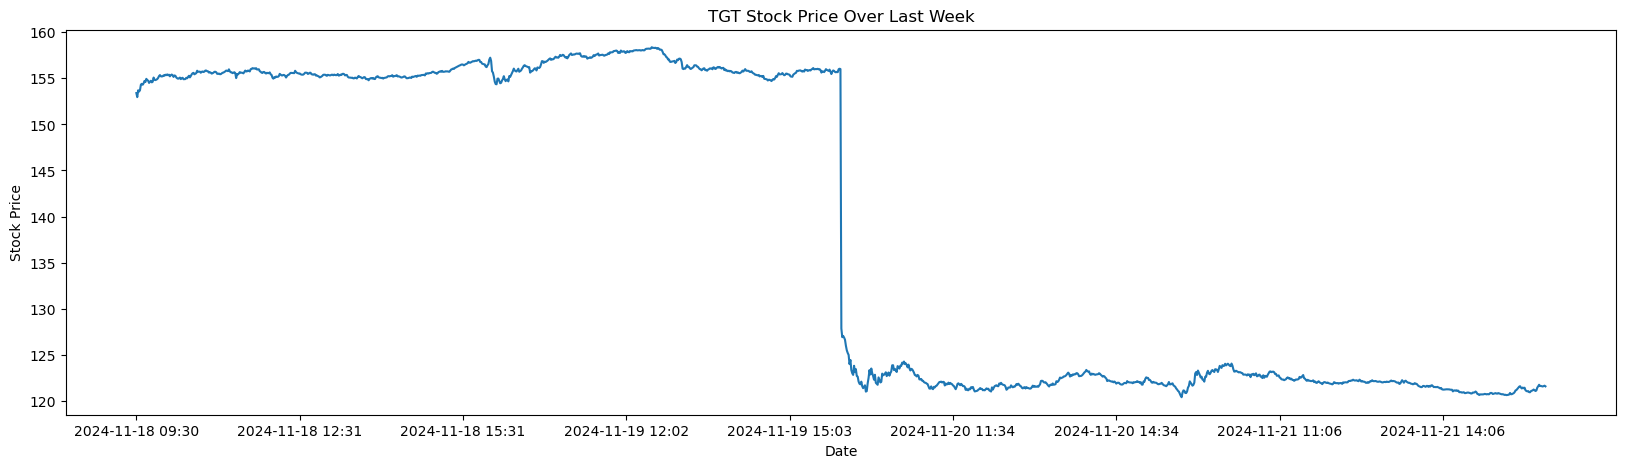

In [55]:
#Target
tgt_history = yf.Ticker('TGT').history(start='2024-11-18', end='2024-11-22', interval='1m')['Close']
tgt_history.index = tgt_history.index.strftime('%Y-%m-%d %H:%M')
plt.figure(figsize=(20, 5))
plt.title('TGT Stock Price Over Last Week')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.plot(tgt_history)
plt.xticks(tgt_history.index[::180])
plt.show()

## Export to CSV File

Lastly, our stocks can be found in the `Stocks_Group_10.csv` file created.

In [56]:
Stocks_Final = pd.DataFrame(index=Portfolio_Final.index, columns=['Ticker', 'Shares'])
Stocks_Final['Ticker'] = Portfolio_Final['Ticker']
Stocks_Final['Shares'] = Portfolio_Final['Shares']
Stocks_Final.drop('Total', inplace=True)
Stocks_Final.to_csv("Stocks_Group_10.csv")